# <center>用Python实现STFT的几种方法</center> 

### <center> 方法1: 通过scipy.signal.stft计算STFT</center> 

[参考](https://blog.csdn.net/qq7835144/article/details/88887576)

In [1]:
import scipy.io.wavfile
import matplotlib.pylab as plt
import numpy as np
import scipy.signal as sig


import warnings
warnings.filterwarnings('ignore')

In [4]:
# read a wav file
sample_rate,x = scipy.io.wavfile.read("5.wav")
length = x.shape[0] / sample_rate
time = np.linspace(0., length, x.shape[0])
#plt.plot(time, x[:])

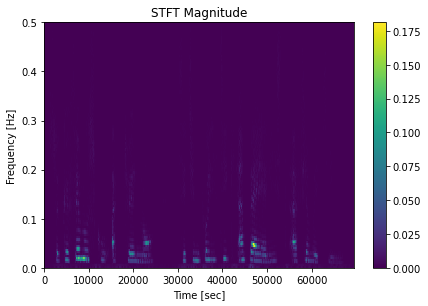

In [19]:
def stft_spectrogram(x, **params):
    f,t,zxx = sig.stft(x, **params)
    cm=plt.cm.get_cmap('flag')
    plt.pcolormesh(t,f,np.abs(zxx),vmin=0)
    plt.colorbar()
    plt.tight_layout()
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

stft_spectrogram(x)

### <center> 方法2: 通过librosa.stft计算STFT</center> 

[参考1](https://www.jianshu.com/p/fc569aed6156)

[参考2](https://www.cnblogs.com/LXP-Never/p/11558302.html#%E4%BA%8C%E3%80%81%E7%9F%AD%E6%97%B6%E5%82%85%E9%87%8C%E5%8F%B6%E5%8F%98%E6%8D%A2stft)

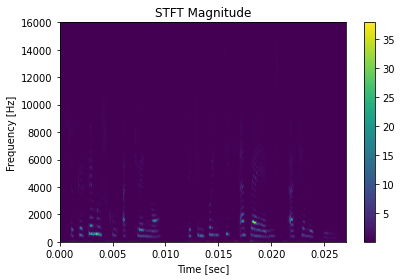

In [22]:
import librosa

fs = 16000
n_fft = 1024

f = fs*np.array(range(int(1+n_fft/2)))/(n_fft/2)

path = "5.wav"

data = librosa.load(path,sr=fs)

length = len(data[0])

spec = np.array(librosa.stft(data[0], n_fft=1024, hop_length=160, win_length=400, window='hann'))

plt.pcolormesh(np.array(range(int(length/160+1)))/fs, f, np.abs(spec))
plt.colorbar()
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()


### <center> 方法3: 通过自写方程计算STFT</center> 

[参考](https://zhen8838.github.io/2019/04/25/stft-1/)

[参考](https://hanspond.github.io/2018/09/18/STFT%20and%20CWT/index.html)

In [6]:
from scipy import ceil, complex64, float64, hamming, zeros
from scipy.fftpack import fft
from scipy import ifft 
from scipy.io.wavfile import read
from matplotlib import pylab as plt

In [8]:
def stft(x, win, step):
    l = len(x) # 输入信号长度
    N = len(win) # 窗长度
    M = int(ceil(float(l - N + step) / step)) # 频谱图spectrogram的frame数，上面公式的m
    new_x = zeros(int(N + ((M - 1) * step)), dtype = float64) 
    new_x[: l] = x # 如有必要，原信号适当延长，右边补零
    X = zeros([M, N], dtype = complex64) # spectrogram初始化, M行N列
    for m in range(M):
        start = step * m   
        end = start + N
        X[m, :] = fft(new_x[start : end] * win)  # 每帧信号和窗函数相乘后，fft得出X的每行m的频率
    return X

def istft(X, win, step):
    M, N = X.shape
    assert (len(win) == N), "FFT length and window length are different."
    l = (M - 1) * step + N     # 原信号长度
    x = zeros(l, dtype = float64)    # 初始化信号
    wsum = zeros(l, dtype = float64)    
    for m in range(M):
        start = step * m
        end = start + N
        x[start : end] = x[start : end] + ifft(X[m, :]).real * win # 对X的每行进行ifft代入相应的时间
        wsum[start : end] += win ** 2  # 求窗函数的功率，得出归一化系数
    pos = (wsum != 0)  
    x_pre = x.copy()
    x[pos] /= wsum[pos]  # 除以窗函数功率进行归一化
    return x

In [14]:
import numpy as np
import librosa

sampling_freq=100
x = np.arange(0, 10, 1/sampling_freq)
y = 5 * np.sin(2 * np.pi * 2 * x)  + 2 * np.sin(2 * np.pi * 5 * x)   + 10 * np.cos(2 * np.pi * 10 * x)   
freq_max=int(sampling_freq/2)    # this is the maximum frequency detectable, according to the uncertainty principle 由采样定理可知
time_max=x.max()
fftLen = 512  # FFT点数
win = hamming(fftLen)  #汉明窗
step = fftLen // 4   # hop size选为1/4个FFT点数
print(y.shape)


path = "p282_023.wav"
y = librosa.load(path,sr=16000)


### STFT
spectrogram = stft(y, win, step)
### iSTFT
resyn_data = istft(spectrogram, win, step)
### Plot
plt.rcParams['figure.figsize'] = (20, 12)
fig = plt.figure()
fig.add_subplot(311)
plt.plot(y)
plt.xlim([0, len(y)])
plt.title("Input signal", fontsize = 20)
fig.add_subplot(312)
plt.imshow(abs(spectrogram[:, : fftLen // 2 + 1].T), extent=[0, time_max, 0.1, freq_max], aspect = "auto", origin = "lower") # 这里选用numerical scale
plt.title("Spectrogram", fontsize = 20)
fig.add_subplot(313)
plt.plot(resyn_data)
plt.xlim([0, len(resyn_data)])
plt.title("Resynthesized signal", fontsize = 20)
plt.show()

(1000,)


AttributeError: 'tuple' object has no attribute 'shape'